In [1]:
from epydemix.model import load_predefined_model
from epydemix.visualization import plot_quantiles
import numpy as np
import pandas as pd
import time

# Speeding Up Simulations and Calibration with Multiprocessing

In this tutorial, we’ll see how to speed up simulations and calibration using **multiprocessing**. Multiprocessing allows you to run computations on multiple CPU cores simultaneously, significantly reducing execution time for computationally intensive tasks.

In Python, parallelization can be achieved in several ways. In this tutorial, we’ll use the [**`multiprocess`**](https://pypi.org/project/multiprocess/) package — a fork of the standard library **`multiprocessing`** module. We prefer `multiprocess` because it integrates better with Jupyter notebooks.

Before we begin, make sure the **`multiprocess`** package is installed:

In [2]:
pip install multiprocess

Note: you may need to restart the kernel to use updated packages.


In [3]:
import multiprocess as mp

## Parallelizing a Simple SIR Model

In this first example, we’ll parallelize the `run_simulations` method of the `EpiModel` class to demonstrate how to integrate **epydemix** with **multiprocess**, and to observe the resulting computational speedup.

We’ll start by creating a standard **SIR** model and measuring the time required to run 50 simulations, each spanning one year:

In [4]:
# create model
model = load_predefined_model("SIR")
Nsim = 50

# run and time the simulations
start = time.time()
sim_results = model.run_simulations(Nsim=Nsim)
end = time.time()

print(f"Time taken: {end - start:.2f} seconds")

Time taken: 3.18 seconds


Let’s now see how to **parallelize** this code. The goal is to distribute multiple simulation runs across different CPU cores so they can be executed simultaneously. This can be achieved in just a few steps:

1. **Wrap the simulation call:**
   Define a small wrapper function around `run_simulations` that takes as input the number of simulations to run. This makes it easier to assign independent chunks of work to each process.

2. **Create a multiprocessing pool:**
   Use a `multiprocess.Pool` object to launch several parallel processes. Each process will execute the wrapper function and run a subset of the total number of simulations.

3. **Combine the results:**
   Once all parallel tasks are complete, collect and merge their outputs (e.g., by stacking lists) into a single result for further analysis.

This approach allows you to take full advantage of multicore CPUs, reducing total computation time, which is especially useful when running large number of simulations or computationally expensive models.

In [5]:
def run_simulations(Nsim):
    """ Wrapper function to run simulations. """
    results = model.run_simulations(Nsim=Nsim)
    return results

# define the number of parallel processes
nprocs = 5

# run and time the simulations in parallel
start = time.time()
with mp.Pool() as pool:
    pool_sim_results = pool.map(run_simulations, [Nsim//nprocs for _ in range(nprocs)])
end = time.time()

print(f"Time taken: {end - start:.2f} seconds")

Time taken: 0.88 seconds


This parallel implementation took roughly 25% of the time required for the classic serial execution, an impressive 4× speed improvement.

However, the output is now a list containing the results from each process, i.e., a list of ```SimulationResults``` objects. To fully leverage epydemix’s features for exploring and visualizing simulation outcomes, we need to combine these results into a single ```SimulationResults``` object.

This can be done easily by concatenating the trajectories from each process, since the model parameters are identical across all runs. The following code snippet shows how to perform this merge step:

In [6]:
from epydemix.model.simulation_results import SimulationResults

merged_results = SimulationResults(
    trajectories=list(np.concatenate([res.trajectories for res in pool_sim_results])), 
    parameters=pool_sim_results[0].parameters)

Finally, we can visualize the combined results just as we normally would, using the standard plotting utilities provided by epydemix:

<Axes: >

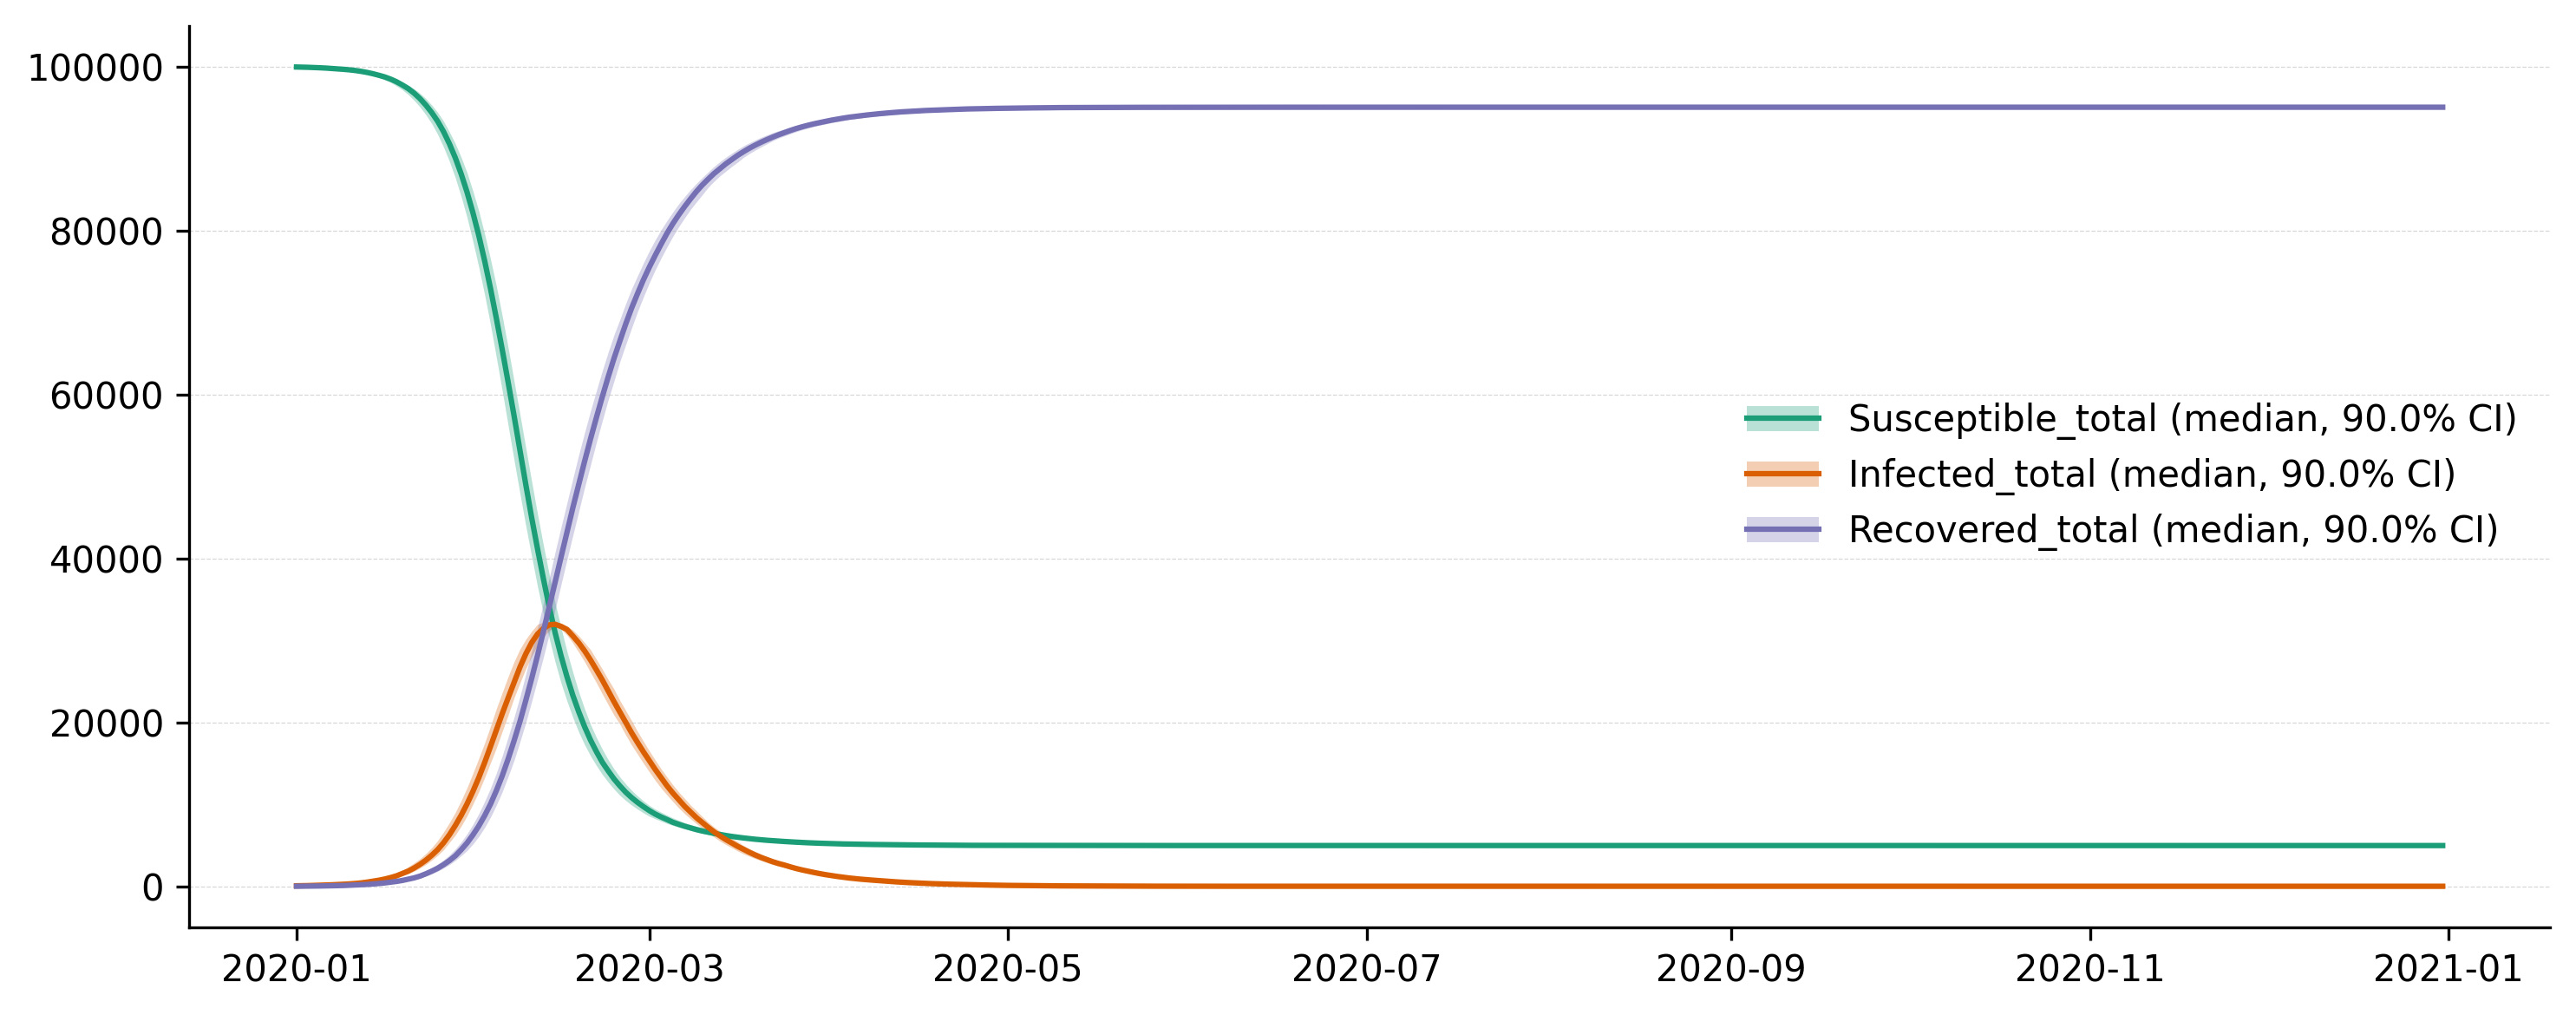

In [7]:
df_quantiles = merged_results.get_quantiles_compartments()
plot_quantiles(df_quantiles, columns=["Susceptible_total", "Infected_total", "Recovered_total"], legend_loc="center right")

## Parallelizing ABC Calibration

In this second example, we’ll demonstrate how to **parallelize the ABC calibration algorithm**. We assume that you’re already familiar with the basics of ABC calibration in **epydemix**. If not, you can refer to the dedicated tutorials (Tutorial 4 and Tutorial 5) as well as the official documentation, where the algorithm’s principles and workflow are explained in detail.

Here, we’ll reuse the same dataset and model setup introduced in **Tutorial 4**: an **SIR model** calibrated to daily incidence data, using population data from **Indonesia**:

In [8]:
from epydemix.utils import compute_simulation_dates
from epydemix.calibration import ABCSampler, rmse
from epydemix.model import simulate
from scipy import stats 

# import data 
data = pd.read_csv('./data/incidence_data.csv')
data["date"] = pd.to_datetime(data["date"])

# import model and set population
model = load_predefined_model("SIR")
model.import_epydemix_population(population_name="Indonesia")

# initial conditions (we assume fully S population except for 0.05% infected individual across age groups)
initial_conditions = {"Susceptible": model.population.Nk - (model.population.Nk * 0.05 / 100).astype(int), 
                      "Infected": (model.population.Nk * 0.05/100).astype(int),
                      "Recovered": np.zeros(len(model.population.Nk))}

# simulation dates 
simulation_dates = compute_simulation_dates(start_date=data.date.values[0], end_date=data.date.values[-1])

# simulation parameters
parameters = {"initial_conditions_dict": initial_conditions,
              "epimodel": model, 
              "start_date": data.date.values[0],
              "end_date": data.date.values[-1]}

# define priors
priors = {"transmission_rate": stats.uniform(0.010, 0.020), 
          "recovery_rate": stats.uniform(0.15, 0.1)}      

# define the wrapper function
def simulate_wrapper(parameters): 
    results = simulate(**parameters)
    return {"data": results.transitions["Susceptible_to_Infected_total"]}

# initialize the ABCSampler object
abc_sampler = ABCSampler(simulation_function=simulate_wrapper, 
                         priors=priors, 
                         parameters=parameters, 
                         observed_data=data["data"].values, 
                         distance_function=rmse)

We are now ready to **run the calibration**. In this example, we’ll use the **ABC rejection algorithm**, but the same approach can be easily adapted to other ABC strategies available in **epydemix**.

As a first step, let’s run the ABC rejection algorithm **without multiprocessing** to establish a baseline and measure how long the serial execution takes:

In [9]:
start = time.time()
results_abc_rejection = abc_sampler.calibrate(strategy="rejection", 
                                              num_particles=100, 
                                              epsilon=550000, verbose=False)
end = time.time()

print(f"Time taken: {end - start:.2f} seconds")

Time taken: 48.30 seconds


Next, we’ll run the same calibration using **multiprocessing**. The procedure closely follows the approach used earlier to parallelize simulations:

1. Define a lightweight wrapper function around the calibration routine.
2. Create a `multiprocess.Pool` to launch several parallel processes.
3. Collect and harmonize the results once all processes have completed.

In this case, we parallelize the computation by running **multiple independent ABC rejection algorithms** in parallel, each responsible for accepting a fraction of the total number of desired particles.
For example, if we aim to accept **100 particles in total**, we can launch **5 parallel processes**, each configured to accept **20 particles**.

In [10]:
def run_calibration(nparticles):
    """ Wrapper function to run simulations. """
    results_abc_rejection = abc_sampler.calibrate(strategy="rejection", 
                                                  num_particles=nparticles, 
                                                  epsilon=550000, verbose=False)
    return results_abc_rejection

# define the number of parallel processes
nprocs = 5
nparticles = 100

# run and time the calibration in parallel
start = time.time()
with mp.Pool() as pool:
    pool_abc_rejection = pool.map(run_calibration, [nparticles//nprocs for _ in range(nprocs)])
end = time.time()

print(f"Time taken: {end - start:.2f} seconds")

Time taken: 9.89 seconds


Once again, parallelization yielded roughly a **4-5× speed improvement** for the calibration process. As before, we now need to **collect and harmonize** the outputs from each process. This is done by creating a single `CalibrationResults` object that combines the results from all subprocesses.

Because `CalibrationResults` objects are more complex than `SimulationResults` (i.e., containing additional attributes such as accepted parameters, distances, and posterior weights) the merging step requires a few more lines of code. Conceptually, however, the process is the same: gather and stack outputs from each subprocess into a unified result.

To make this step easier and reusable, we’ll define a **utility function** that performs this harmonization. Users can then **export and extend** this function for their own workflows or for other ABC algorithms.

In [ ]:
from epydemix.calibration.calibration_results import CalibrationResults

def merge_calibration_results(result, calibration_strategy):
    """ Merge calibration results from multiple processes. """
    posterior_distributions, selected_trajectories, distances, weights = {}, {}, {}, {}

    for res in result:

        ## posterior distributions
        for k in res.posterior_distributions.keys():
            if k not in posterior_distributions.keys():
                posterior_distributions[k] = res.posterior_distributions[k]
            else: 
                posterior_distributions[k] = pd.concat([posterior_distributions[k], res.posterior_distributions[k]], ignore_index=True)

        ## selected trajectories
        for k in res.selected_trajectories.keys():
            if k not in selected_trajectories.keys():
                selected_trajectories[k] = res.selected_trajectories[k]
            else: 
                selected_trajectories[k] = np.concatenate([selected_trajectories[k], res.selected_trajectories[k]])

        ## distances
        for k in res.distances.keys():
            if k not in distances.keys():
                distances[k] = res.distances[k]
            else: 
                distances[k] = np.concatenate([distances[k], res.distances[k]])

        ## weights
        for k in res.weights.keys():
            if k not in weights.keys():
                weights[k] = res.weights[k]
            else: 
                weights[k] = np.concatenate([weights[k], res.weights[k]])

    # normalize weights
    for k in weights.keys():
        weights[k] = weights[k] / np.sum(weights[k])

    merge_cal_results = CalibrationResults(
        calibration_strategy=calibration_strategy, 
        posterior_distributions=posterior_distributions,
        selected_trajectories=selected_trajectories,
        observed_data=result[0].observed_data, 
        priors=result[0].priors, 
        distances=distances, 
        weights=weights)

    return merge_cal_results


merged_abc_rejection_results = merge_calibration_results(pool_abc_rejection, "rejection")

Finally, we can use the merged `CalibrationResults` object to **explore and analyze** the calibration outputs as usual:

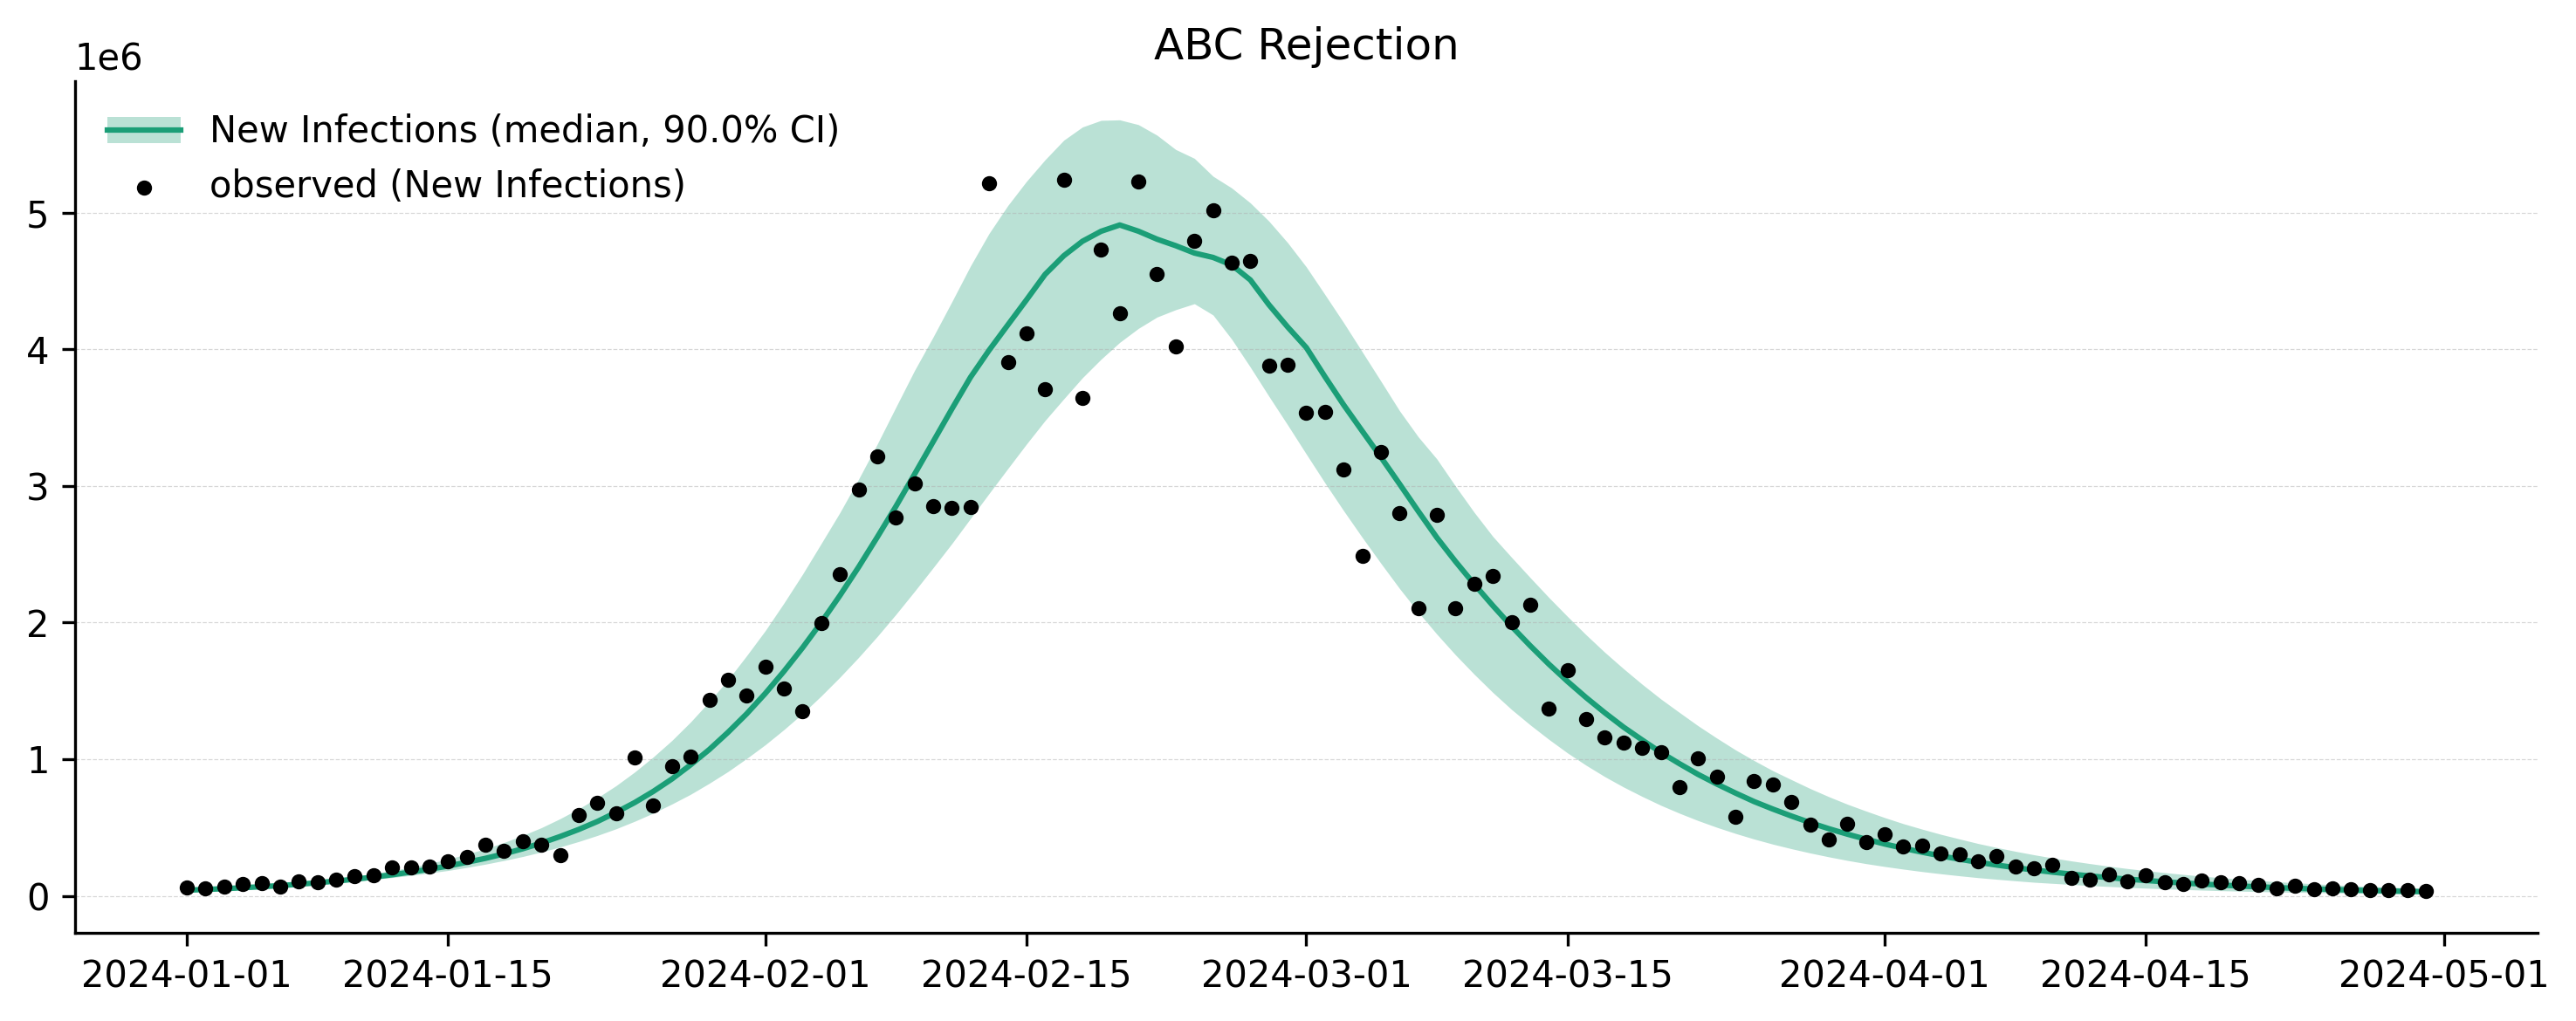

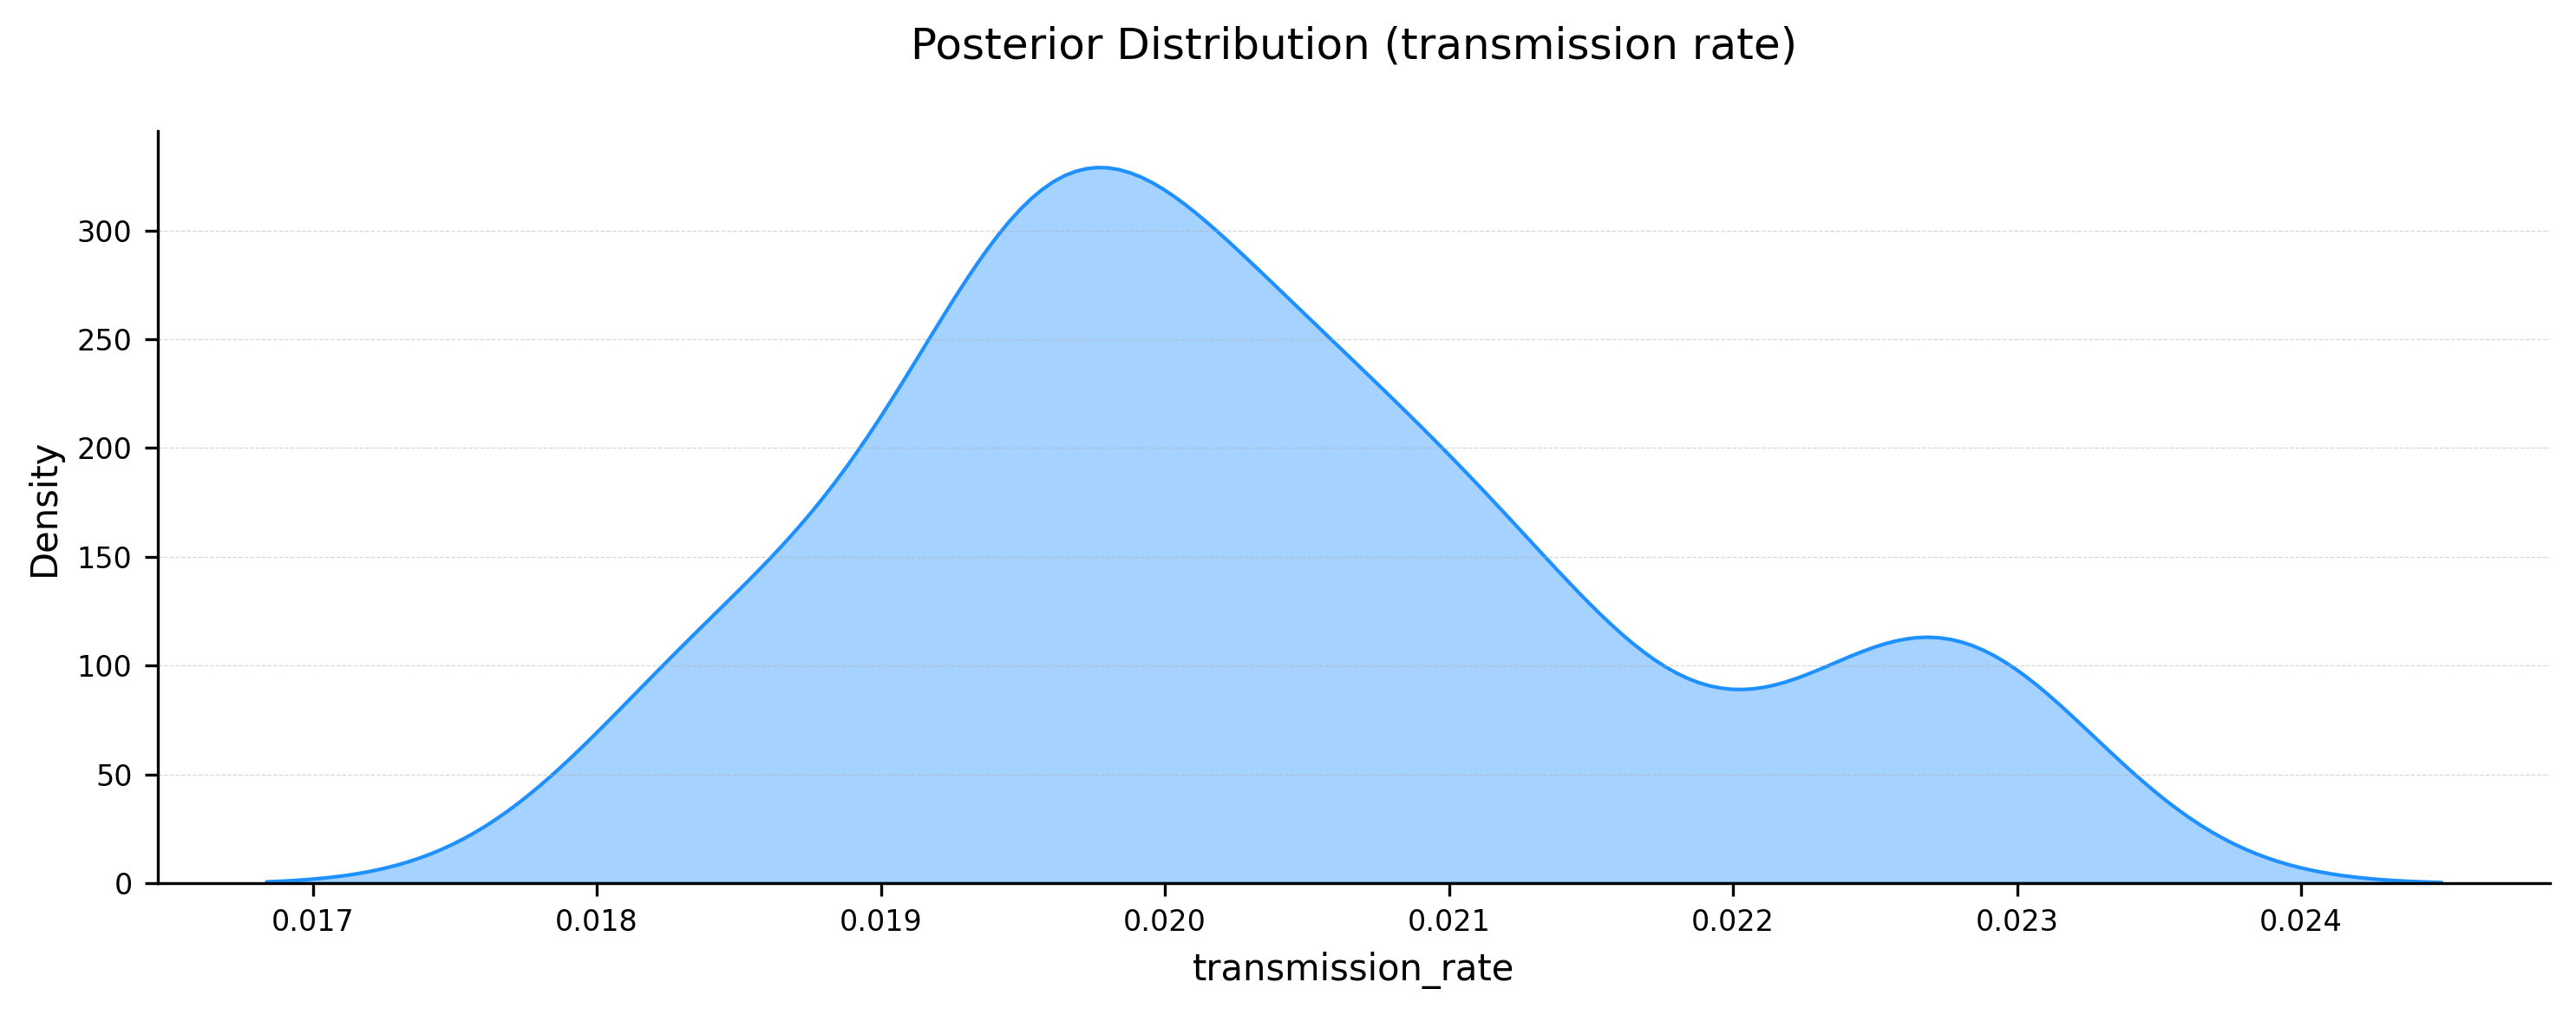

In [20]:
from epydemix.visualization import plot_quantiles, plot_posterior_distribution, plot_posterior_distribution_2d

# compute quantiles 
df_quantiles_abc = merged_abc_rejection_results.get_calibration_quantiles(dates=simulation_dates)

# plot selected trajectories quantiles
plot_quantiles(
    df_quantiles_abc, 
    columns="data", 
    data=data, 
    title="ABC Rejection", 
    show_data=True, labels=["New Infections"]) 

# plot posterior distribution
plot_posterior_distribution(
    merged_abc_rejection_results.get_posterior_distribution(), 
    "transmission_rate",  
    title="Posterior Distribution (transmission rate)", 
    kind="kde", prior_range=False);

**Note:**
Both the **ABC Rejection** and **Top X% Simulations** algorithms are *trivially parallelizable*.
As we’ve seen, in the case of the ABC Rejection algorithm, we can simply run multiple instances in parallel, each accepting a fraction of the total target number of particles.
Similarly, the Top X% Simulations algorithm can be parallelized by running multiple instances, each handling a portion of the total simulation budget.

For the **ABC-SMC** algorithm, multiprocessing can also be applied; however, users should interpret the combined results with caution. In particular, weights originating from separate SMC runs may not be directly comparable, so stacked results might only provide an approximation rather than an exact merged posterior.